In [1]:
# Tile level classifier - Tiles generated from WSI slides of LGG, GBM of TCGA dataset
# A multi classes image classifier, based on convolutional neural network using Keras and Tensorflow. 
# A multi-label classifier (having one fully-connected layer at the end), with multi-classification (2 classes, in this instance)
# Largely copied from the code https://github.com/kallooa/MSDA_Capstone_Final/tree/master/3_Model_Training/Tile_Level_Model_Training
# classifying 2 cancer types (LGG, GBM tiles generated from 1 WSI slide, around 270,000 tiles) downloaded from candygram.emory.edu
# Thumbnail extraction and tile extraction from WSI slides are implemented using HistomicsTK (https://girder.readthedocs.io/en/latest/)
# Used Keras.ImageDataGenerator for Training/Validation data augmentation and the augmented images are flown from respective directory
# train folder has training images and test folder has test images
# val folder has validation images, autogenerated by keras 
# Environment: A docker container having Keras, TensorFlow, Python-3 with GPU based execution

# 1024 - FCNs

In [2]:
!pip install nvidia-ml-py3 --user

You are using pip version 10.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Convolution2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
from keras.callbacks import Callback
from keras.optimizers import adagrad, adadelta, rmsprop, adam
from keras.utils import np_utils
from keras.regularizers import l2
from sklearn.cross_validation import StratifiedKFold
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
import datetime, time, os, sys
import numpy as np
import h5py
import matplotlib as plt
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import pandas as pd

#import nvidia_smi as nvs - Python 2 version
import pynvml as nvs
sys.setrecursionlimit(10000)

Using TensorFlow backend.
/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Metadata json: GPU

In [4]:
# modelinfo: json to store system metadata:# model 
modelInfo = {}
# GPU/CPU:
modelInfo['Device']  = {}

# initialize GPU to get detailed info:
nvs.nvmlInit()
#nvmlInit()
# Driver version:
driverVersion = nvs.nvmlSystemGetDriverVersion()
# Number of devices:
deviceCount = nvs.nvmlDeviceGetCount()
# Device Names:
deviceNames = []
for i in range(deviceCount):
    handle = nvs.nvmlDeviceGetHandleByIndex(i)
    dvn = nvs.nvmlDeviceGetName(handle) # store the device name
    deviceNames.append(dvn)
nvs.nvmlShutdown()
# Save GPU metadata to modelInfo
modelInfo['Device']['driverVersion']  = driverVersion
modelInfo['Device']['deviceNames']  = deviceNames

# User Input:¶

In [10]:
# Image dimension:
img_width, img_height = 150,150
# Epochs
epochs = 2
# Batch size:
batch_size = 25
colormode ="rgb"
channels=3

# Save model metadata to modelInfo:
modelInfo['batch_size'] = batch_size
modelInfo['epochs'] = epochs
modelInfo['img_width'] = img_width
modelInfo['img_height'] = img_height
 

# Training and Validation Images Locations
training_dir = '/data/train'
test_dir = '/data/test'

# Results Location:
results_dir ="/output/results/"

# Basic Image Statistics:¶

In [11]:
# Count training images:
ntraining = 0
for root, dirs, files in os.walk(training_dir):
    ntraining += len(files)

# Getting data format:

In [12]:
# get data format:
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

# Data Augmentation:¶

In [13]:
# Training Data Generator with Augmentation:
# -Scale
# -Shear
# -Zoom
# -Height and Width Shift
# -Fill: Nearest
# -Horizontal Flip

train_datagen = ImageDataGenerator(vertical_flip=True, horizontal_flip=True, validation_split=0.2)

# Validation Data Generator:
# -Scale
val_datagen = ImageDataGenerator(validation_split=0.2)

# Training Data flow from directory:
train_generator = train_datagen.flow_from_directory(
    training_dir,
    target_size=(150,150),
    batch_size=batch_size,
    color_mode=colormode,
    subset='training')

# Validation Data flow from directory:
val_generator = val_datagen.flow_from_directory(
    training_dir, 
    target_size=(150,150),
    batch_size=batch_size,
    color_mode=colormode,
    subset='validation')

# Number of Classes/Labels:
nLabels = len(val_generator.class_indices)

Found 16356 images belonging to 2 classes.
Found 4088 images belonging to 2 classes.


# Model¶

In [14]:
 # create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False)
# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer
predictions = Dense(nLabels, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = True

for layer in model.layers:
    layer.trainable = True

# ompile the model (should be done *after* setting layers to non-trainable)
# create model with for binary output with the adam optimization algorithm
model.compile(optimizer='adadelta', loss='categorical_crossentropy',  metrics=['accuracy'])

# TimeHistory: Callback class to get timings¶

In [15]:
# Timehistory callback to get epoch run times
class TimeHistory(Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

time_callback = TimeHistory()

In [16]:
# To avoid broken stream or IO error for >=100k images
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Model Run

In [17]:
# Model fitting and training run
inception_2_tile_class_model=model.fit_generator(train_generator, steps_per_epoch= ntraining, class_weight='auto',epochs=epochs, validation_data=val_generator, callbacks=[time_callback])
print ("Training Finished")

Epoch 1/2
20444/20444 [==============================] - 6466s 316ms/step - loss: 0.0650 - acc: 0.9808 - val_loss: 0.0135 - val_acc: 0.9951
Epoch 2/2
20444/20444 [==============================] - 6280s 307ms/step - loss: 0.0280 - acc: 0.9928 - val_loss: 0.1914 - val_acc: 0.9552
Training Finished


In [18]:
! mkdir -p /output/results/

# Save Run metadata to modelInfo¶

In [19]:
# Get timestamp:
now = datetime.datetime.now()
filetime = str(now.year)+str(now.month)+str(now.day)+'_'+str(now.hour)+str(now.minute)

# Time per Epoch:
modelInfo['epochTimeInfo'] = time_callback.times

# Save timestamped model to modelfilename
modelfilename=results_dir+'2_tile_class_inception_model_'+filetime+'.h5'
model.save(modelfilename)

# Save Model into .CSV File

In [20]:
hist = inception_2_tile_class_model.history
hist = pd.DataFrame(hist)
hist.to_csv(results_dir+'2_tile_class_inception_model_'+filetime+'.csv')

# Save Run Results to modelInfo:

In [21]:
# Training and Validation accuracy and loss per epoch
modelInfo['historyData'] =  pd.DataFrame(inception_2_tile_class_model.history).to_dict(orient='records')

###target_names maps the character names (or labels) to the index(integer) used in the output files
modelInfo['target_names']  = val_generator.class_indices

modelInfo['labelname_to_index']  = val_generator.class_indices
modelInfo['index_to_labelname']  = {(v,k) for k,v in val_generator.class_indices.items() }

# Run Model on Test Images:

In [22]:
# Get number of Testing Images
nTest = 0
for root, dirs, files in os.walk(test_dir):
    nTest += len(files)

In [52]:
# Testing Data Generator:
# modified to suit histology images - 17th Aug, 2018
#test_datagen = ImageDataGenerator(rescale=1. /255.)
#testing_generator_noShuffle = test_datagen.flow_from_directory(
#    test_dir,
#    target_size=(img_width, img_height),
#    batch_size=batch_size,
#    shuffle=False,
#    class_mode='categorical')

test_datagen = ImageDataGenerator()
testing_generator_noShuffle = test_datagen.flow_from_directory(
    test_dir, 
    target_size=(150,150),
    batch_size=batch_size,
    color_mode=colormode,
    shuffle = False,
    class_mode='categorical')

Found 3895 images belonging to 2 classes.


In [53]:
# predict_Validation: narray
# row= image
# column= probability of falling within label matching column_index
predict_Testing = model.predict_generator(testing_generator_noShuffle)

In [54]:
# Best Prediction for all labels
best_prediction_per_label= [ max( predict_Testing[:,j] ) for j in range( predict_Testing.shape[1] ) ]

# Predicted label for each image:

In [55]:
predicted_labels= []
# Find highest probability in prediction list for each image
for i in predict_Testing:
    i= list(i)
    max_value = max(i) 
    predicted_labels.append( i.index(max_value) )

# Confusion Matrix generation

In [56]:
modelInfo['confusion_matrix'] = confusion_matrix(testing_generator_noShuffle.classes, predicted_labels)

In [57]:
modelInfo['confusion_matrix']

array([[2139,  263],
       [  20, 1473]])

# Confusion Matrix in a Plot

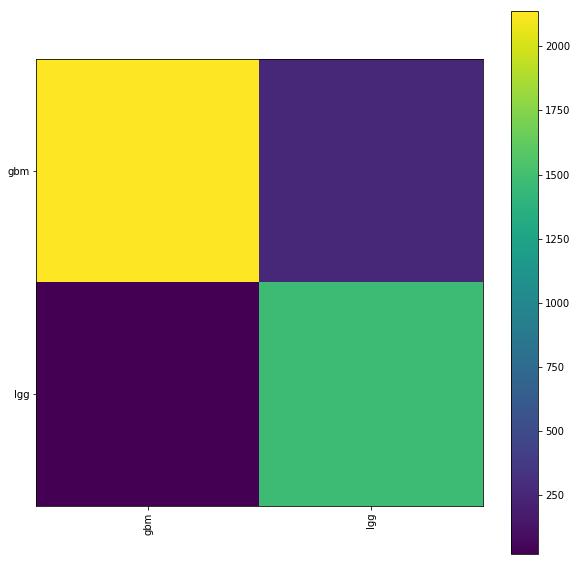

In [58]:
import matplotlib.pyplot as pyplot
pyplot.figure
#target_names = val_generator.class_indices
target_names = testing_generator_noShuffle.class_indices
pyplot.figure(figsize=(10,10))
cnf_matrix = confusion_matrix(testing_generator_noShuffle.classes, predicted_labels)
classes = list(target_names)
pyplot.imshow(cnf_matrix, interpolation='nearest')
pyplot.colorbar()
tick_marks = np.arange(len(classes))  
_ = pyplot.xticks(tick_marks, classes, rotation=90)
_ = pyplot.yticks(tick_marks, classes)
plotopt= results_dir + 'inception_2_tile_class_model_'+filetime+'.png'
pyplot.savefig(plotopt)

In [59]:
cls_rpt = classification_report(testing_generator_noShuffle.classes, predicted_labels, target_names= testing_generator_noShuffle.class_indices)

In [60]:
print(cls_rpt)

             precision    recall  f1-score   support

        gbm       0.99      0.89      0.94      2402
        lgg       0.85      0.99      0.91      1493

avg / total       0.94      0.93      0.93      3895



# Turning into classification report into classification object

In [61]:
avgresults = cls_rpt.strip().split('\n')[-1].split()

In [62]:
overallResults={'label' : 'avg/total', 'precision': avgresults[3], 'recall':avgresults[4],'f1-score':avgresults[5], 'support':avgresults[6]}

In [63]:
precision, recall, fscore, support  =  precision_recall_fscore_support(testing_generator_noShuffle.classes, predicted_labels)

In [64]:
modelInfo['classificationObject'] =  characterResultsArray =  {
    'label':val_generator.class_indices.keys(),
    'precision': precision,
    'recall':recall,
    'fscore': fscore, 'support':support,
    'overallResults':{'label' : 'avg/total', 
                      'precision': avgresults[3], 
                      'recall':avgresults[4],
                      'f1-score':avgresults[5],
                      'support':avgresults[6]}}

In [65]:
modelInfo['classificationObject']

{'fscore': array([0.9379522 , 0.91235677]),
 'label': ['gbm', 'lgg'],
 'overallResults': {'f1-score': u'0.93',
  'label': 'avg/total',
  'precision': u'0.94',
  'recall': u'0.93',
  'support': u'3895'},
 'precision': array([0.99073645, 0.8485023 ]),
 'recall': array([0.89050791, 0.98660415]),
 'support': array([2402, 1493])}

# Create Prediction object for each test image with filename, actual image label, Folder

In [ ]:
import glob
import os
import keras.preprocessing.image as Kimg

modelInfo['imgprediction'] = []

model=load_model(modelfilename)

for fld in os.listdir('/data/test/'): 
    trueLabel = fld
    for img in os.listdir('/data/test/%s/' %trueLabel): 
        imgPath = "/data/test/%s/%s" % (fld, img)
        x = Kimg.load_img(imgPath, target_size=(64,64))
        x = Kimg.img_to_array(x)
        x = x.reshape((1,) + x.shape)
        x = x/255.
        pr=model.predict(x)
        curr = {'filename': img, 'actualImageLabel': fld, 'modelprediction':pr} 
        modelInfo['imgprediction'].append(curr) 

In [ ]:
modelInfo['imgprediction']

# Generates Top3 Predicted images for each individual image in the "test folder" only

In [ ]:
from PIL import Image
import matplotlib.pyplot as pyplot
rows = 2
cols = 2
img_width, img_height = 64, 64
pyplot.figure()
pyplot.show()
fig, ax = pyplot.subplots(rows, cols, frameon=False, figsize=(5, 5))
fig.suptitle('Prediction Images', fontsize=10, y = 1.03)
count=0

modelInfo['imgprediction'] = []

model=load_model(modelfilename)

for fld in os.listdir('/data/test/'): 
    trueLabel = fld          
    for imgname in os.listdir('/data/test/%s/' %trueLabel): 
        for i in range(rows):
            for j in range(cols):
                imgPath = "/data/test/%s/%s" % (fld, imgname)                
                img = Image.open(imgPath)
                img = img.resize((img_width, img_height), Image.ANTIALIAS)
                ax[i][j].imshow(img)
                img = img_to_array(img)
                img = img/255.0
                img = img.reshape((1,) + img.shape)
                pr = model.predict(img, batch_size= 1)                
                curr = {'filename': img, 'actualImageLabel': fld, 'modelprediction':pr} 
                modelInfo['imgprediction'].append(curr)                
                # To show image with top 3 predicted images
                pred = pd.DataFrame(np.transpose(np.round(pr, decimals = 3)))
                pred = pred.nlargest(n = 3, columns = 0) 
                pred['char'] = [list(modelInfo['labelname_to_index'].keys())[list(modelInfo['labelname_to_index'].values()).index(x)] for x in pred.index]
                charstr = ''
                for k in range(0,3):
                    if k < 2:
                        charstr = charstr+str(pred.iloc[k,1])+': '+str(pred.iloc[k,0])+'\n'
                    else:
                        charstr = charstr+str(pred.iloc[k,1])+': '+str(pred.iloc[k,0])                
                ec = (0, .8, .1)
                fc = (0, .9, .2)
                count = count + 1
                ax[i][j].text(0, -10, charstr, size=10, rotation=0,
                      ha="left", va="top", 
                      bbox=dict(boxstyle="round", ec=ec, fc=fc, alpha = 0.7))
                pyplot.setp(ax, xticks=[], yticks=[])
                pyplot.tight_layout(rect=[0, 0.14, 1, 0.95])
                pyplot.savefig('/data/code/results/prediction_'+ str(imgname) + '.png')